# Homework 6: Bootstrapping to estimate parameter ranges of nonlinear models

***
### Academic honesty statement

**SANTIAGO ORTIZ LAVERDE**

- I state that I worked alone on this assignment. Therefore, I take full responsibility for the academic integrity of the work presented below.
***

## Part 2: Use sampling with replacement to create distributions of parameters that fit the data

Our hypothesis is that both a and b are greater than 0. Use the bootstrap method to create distributions of estimates of our parameter values. We can do this by, **for each iteration:**
   - Resample the data at each time point using sample with replacement (search online how to do).
   - Use minimize to refit the model to the resampled data
   - Save the fitted parameter estimates and the value of the cost function.

### 1.1 First task
- Do the previous steps for at least 200 iterations. HINT: this code may take a long time to run. It would be best to get the code working with only a few iterations. And once happy, then try 200. 

In [1]:
using CSV, DataFrames
using BenchmarkTools

dat = CSV.read("Homework 6 Data.csv", DataFrame);
t = dat[!, :Time]
exp1 = dat[!, :Exp1]
exp2 = dat[!, :Exp2]
exp3 = dat[!, :Exp3]
exp4 = dat[!, :Exp4]
exp5 = dat[!, :Exp5]
data_origin = reduce(hcat, [t, exp1, exp2, exp3, exp4, exp5]);

ts = size(data_origin)[1]
Exps = size(data_origin)[2] - 1
N_Cbact = ts*Exps
N_time = copy(N_Cbact);

In [2]:
function fill_array(short; N=N_time, js=ts, ls=Exps)
    long = Array{Float64, 2}(undef, N, 1)
    for j in range(1, js)
        f = (j-1)*ls
        long[1+f:ls+f] = short[j]*ones(ls)
    end
    long
end

function bootstrap(data; N=N_Cbact, js=ts, ls=Exps)
    Ytraining = Array{Float64, 2}(undef, N, 1)
    for j in range(1, js)
        f = (j-1)*ls
        Ytraining[1+f:ls+f] = rand(data[j, 2:end], (1, ls))
    end
    Ytraining
end;

In [3]:
using DifferentialEquations, Statistics

function bacterial_model!(du, u, p, t)
    a, b = p
    y = u[1]
    du[1] = dydt = y^3/(a + y^3) - b*y
end;

u0 = [mean(data_origin[1, 2:end])]
tspan = (10.0, 50.0)
p = [0.3, 0.8]
prob = ODEProblem(bacterial_model!, u0, tspan, p);

In [4]:
function RMSE(p, training_data; prob=prob, t=t)
    prob = remake(prob; u0=[mean(training_data[1:Exps])], p=p)
    ODE_output = convert(Array, solve(prob, Tsit5(), saveat=t))
    err = training_data .- fill_array(ODE_output; N=N_Cbact)
    sqrt(sum(err.^2))
end;

In [5]:
using Optim

function Bootstrapping(data, guess; iter=200, lower=fill(0.0, 2), upper=fill(1.0, 2))
    SAmIn = SAMIN(rt=0.1, verbosity=0)
    options = Optim.Options(iterations=10^6)    
    estimation = Array{Float64, 2}(undef, iter, length(guess)+1)
    for i in range(1, iter)
        f(p) = RMSE(p, bootstrap(data))
        res = Optim.optimize(f, lower, upper, guess, SAmIn, options)
        estimation[i, 1] = Optim.minimum(res)
        estimation[i, 2:end] = Optim.minimizer(res)
    end
    estimation
end;

In [6]:
estimations = Bootstrapping(data_origin, [0.3, 0.8]; iter=1000, lower=[-1000, 0.0], upper=[1000, 1.0]);
f_dist = estimations[:, 1]
a_dist = estimations[:, 2]
b_dist = estimations[:, 3];

### 1.2 Second task
- After completing, plot histograms of the fitted parameter values and cost function values. Figures must be clearly labeled and obvious to read. 

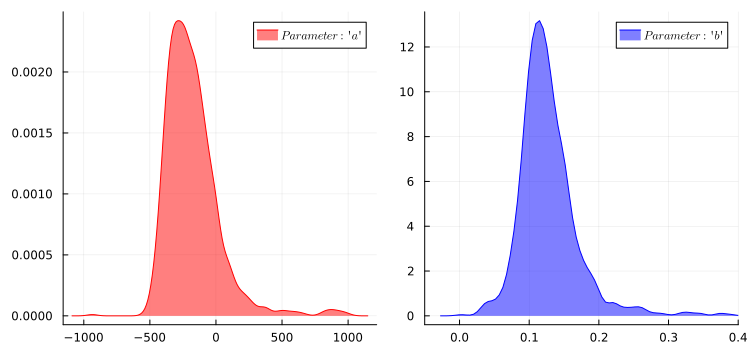

In [7]:
using StatsPlots, LaTeXStrings

a_dens = density(a_dist, color=:red, fill=(0, .5, :red), label=L"Parameter: 'a'")
b_dens = density(b_dist, color=:blue, fill=(0, .5, :blue), label=L"Parameter: 'b'", xlims=(-0.05, 0.4))
plot(a_dens, b_dens, layout=(1, 2), size=(750, 350))

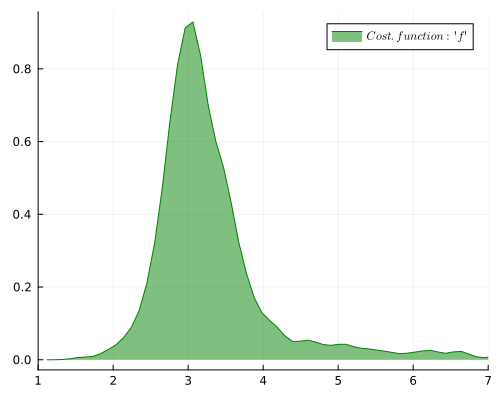

In [8]:
f_dens = density(f_dist, color=:green, fill=(0, .5, :green), label=L"Cost.function: 'f'")
plot!(f_dens, size=(500, 400), xlims=(1., 7.))

### 1.2 Second task
- Based on these data, what is the p value for the null hypothesis that a and b are equal to zero? Calculate the one sided p value, based on the idea that we expect them to be greater than zero.

In [9]:
condition_range(dist; cv=0.0, tol=1E-5) = dist.>cv-tol .&& dist.<cv+tol

pvalue_a0 = sum(condition_range(a_dist; tol=0.2))/length(a_dist)
pvalue_b0 = sum(condition_range(b_dist; tol=1E-2))/length(b_dist)

pvalue_a = sum(a_dist .>= 0.0)/length(a_dist)
pvalue_b = sum(b_dist .>= 0.0)/length(b_dist)

printstyled("p-value for: 'parameter a ~= 0.0' is equal to $(pvalue_a0) \n"; color=:blue)
printstyled("p-value for: 'parameter b ~= 0.0' is equal to $(pvalue_b0) \n"; color=:blue)
printstyled("p-value for: 'parameter a >= 0.0' is equal to $(pvalue_a) \n"; color=:red)
printstyled("p-value for: 'parameter b >= 0.0' is equal to $(pvalue_b) \n"; color=:red)

p-value for: 'parameter a ~= 0.0' is equal to 0.001 
p-value for: 'parameter b ~= 0.0' is equal to 0.001 
p-value for: 'parameter a >= 0.0' is equal to 0.132 
p-value for: 'parameter b >= 0.0' is equal to 1.0 


***